From Macoslo's google drive:
```bash
gsutil -m cp -r gs://macosko_data/schen/bcl/cleaned/* .
```

In [ ]:
import os
import anndata as ad
import scanpy as sc

TISSUE="DFC"
input_dir = f"/home/gdallagl/myworkdir/XDP/data/XDP/NucSec/original_data/{TISSUE}"
output_file = f"/home/gdallagl/myworkdir/XDP/data/XDP/NucSec/original_data/{TISSUE}_combined_raw.h5ad"
final_merged = f"{os.path.dirname(output_file)}/NucSeq_all_QCed.h5ad"

In [ ]:
h5ad_files = sorted(
    f for f in os.listdir(input_dir) if f.endswith(".h5ad")
)
print(h5ad_files)

combined = None

for fname in h5ad_files:

    path = os.path.join(input_dir, fname)
    cell_type = fname.replace(".h5ad", "")

    # Read one file at a time
    adata = sc.read_h5ad(path)
    print(adata)
    #print(adata.X)

    # --- keep only raw counts and obs ---
    # If raw counts are in adata.X, this is sufficient
    adata = ad.AnnData(
        X=adata.X,
        obs=adata.obs.copy(),
        var=adata.var.copy()
    )

    # --- add required obs columns ---
    adata.obs["tissue"] = TISSUE
    adata.obs["broad_original_cell_type"] = cell_type

    # --- incremental concatenation ---
    if combined is None:
        combined = adata
    else:
        combined = ad.concat(
            [combined, adata],
            axis=0,
            join="inner",
            merge="same"
        )

    # Explicit cleanup
    del adata

# Write final object
combined.write_h5ad(output_file)


AnnData object with n_obs × n_vars = 17645 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'barcode', 'bcl', 'rna_index', 'library', 'library__barcode', 'frac_mito', 'mol_info_nUMI', 'mol_info_nRead', 'frac_intronic', 'donor_id', 'vireo_prob_max', 'vireo_prob_doublet', 'vireo_n_vars', 'vireo_best_singlet', 'vireo_best_doublet', 'vireo_doublet_logLikRatio', 'dropsift_frac_contamination', 'dropsift_training_label_is_cell', 'dropsift_empty_gene_module_score', 'dropsift_is_cell', 'dropsift_is_cell_prob', 'cell_class', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'log_nUMI'
    var: 'highly_variable'
    uns: 'cell_class_colors', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'gene_expression_encoding'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 2813 × 38606
    obs: 'background_fracti

In [ ]:
h5ad_files = sorted(
    f for f in os.listdir(os.path.dirname(output_file)) if f.endswith(".h5ad")
)
print(h5ad_files)

combined = None

for fname in h5ad_files:
    
    path = os.path.join(os.path.dirname(output_file), fname)
    cell_type = fname.replace(".h5ad", "")

    # Read one file at a time
    adata = sc.read_h5ad(path)
    print(adata)
    #print(adata.X)

    # --- incremental concatenation ---
    if combined is None:
        combined = adata
    else:
        combined = ad.concat(
            [combined, adata],
            axis=0,
            join="inner",
            merge="same"
        )

    # Explicit cleanup
    del adata

['DFC_combined_raw.h5ad', 'SN_combined_raw.h5ad', 'Striatum_combined_raw.h5ad']
AnnData object with n_obs × n_vars = 170411 × 38601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'barcode', 'bcl', 'rna_index', 'library', 'library__barcode', 'frac_mito', 'mol_info_nUMI', 'mol_info_nRead', 'frac_intronic', 'donor_id', 'vireo_prob_max', 'vireo_prob_doublet', 'vireo_n_vars', 'vireo_best_singlet', 'vireo_best_doublet', 'vireo_doublet_logLikRatio', 'dropsift_frac_contamination', 'dropsift_training_label_is_cell', 'dropsift_empty_gene_module_score', 'dropsift_is_cell', 'dropsift_is_cell_prob', 'cell_class', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'tissue', 'broad_original_cell_type'
AnnData object with n_obs × n_vars = 151968 × 38601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'barcode', 'bcl', 'rna_index', 'library', 'library__barcode', 'frac_mito', 'mol_info_nUMI', 'mol_info_nRea

# QC

In [1]:
%load_ext autoreload
%autoreload 2

import os
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
from utils import preprocessing
import pandas as pd


In [2]:
adata = sc.read_h5ad("/home/gdallagl/myworkdir/XDP/data/XDP/NucSec/original_data/NucSeq_all_labelled_zoned.h5ad")#, backed="r")
adata

AnnData object with n_obs × n_vars = 606390 × 38601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'barcode', 'bcl', 'rna_index', 'library', 'library__barcode', 'frac_mito', 'mol_info_nUMI', 'mol_info_nRead', 'frac_intronic', 'donor_id', 'vireo_prob_max', 'vireo_prob_doublet', 'vireo_n_vars', 'vireo_best_singlet', 'vireo_best_doublet', 'vireo_doublet_logLikRatio', 'dropsift_frac_contamination', 'dropsift_training_label_is_cell', 'dropsift_empty_gene_module_score', 'dropsift_is_cell', 'dropsift_is_cell_prob', 'cell_class', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'tissue', 'broad_original_cell_type', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Neighborhood_correlation_coefficient', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Class_correlation_coefficient', 'Subclass_label', 'Subclass_name'

In [3]:
# Calculate qc
    # attention: need raw counts in .X
adata.X = adata.layers["counts"].copy()
adata.var["mt"] = adata.var.gene_symbol.str.startswith("MT-") # mitochondrial genes, ATTNETION: the names are in "gene_symbol"
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

/home/gdallagl/myworkdir/XDP/utils/preprocessing.py:67: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  sorted_idx = adata.obs["pct_counts_mt"].argsort()


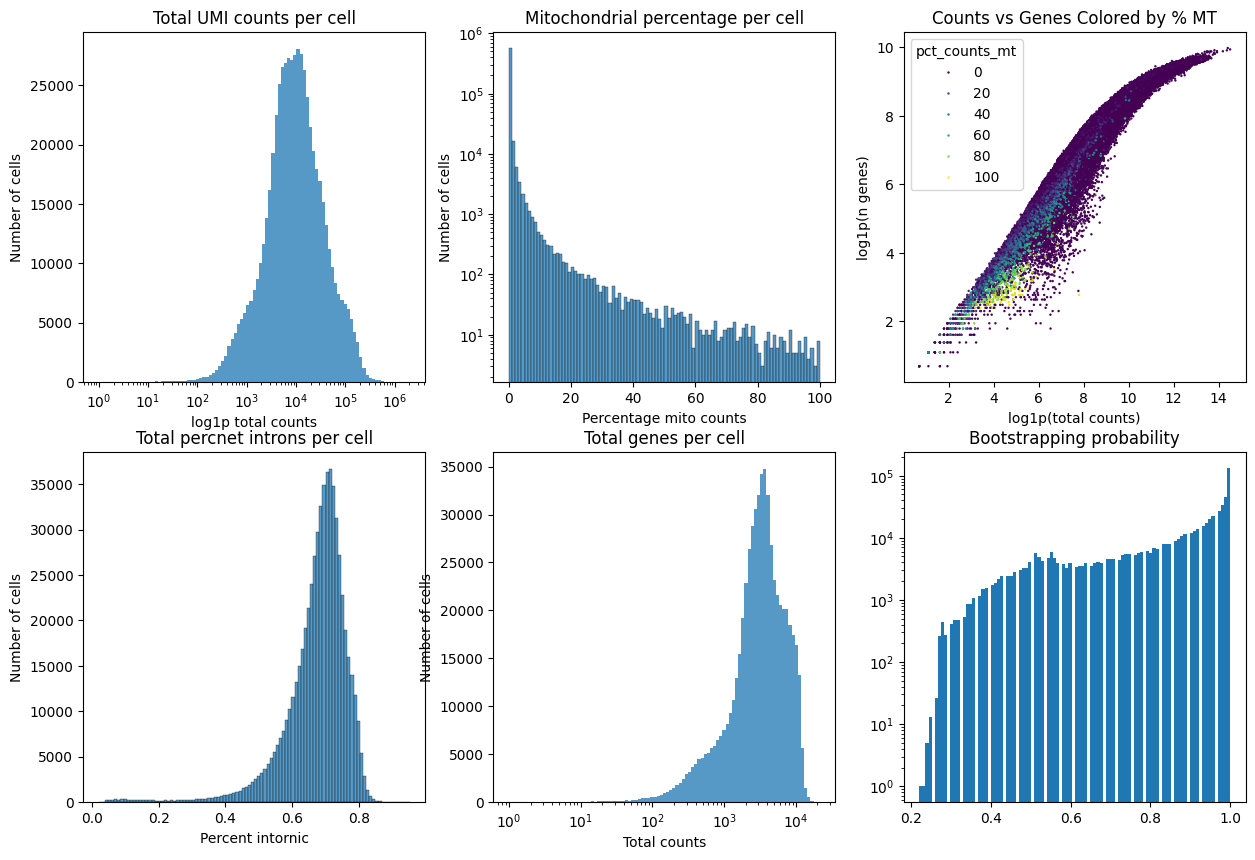

In [4]:
preprocessing.plot_qc_metrics(adata, pct_intronic_col="frac_intronic")

Text(0.5, 0.98, 'dropsift_frac_contamination')

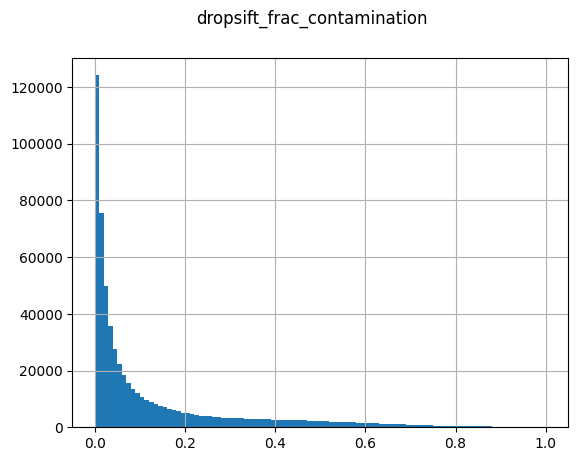

In [6]:


adata.obs["dropsift_frac_contamination"].hist(bins=100)
plt.suptitle("dropsift_frac_contamination")

In [7]:
import scipy.sparse as sp
adata.X = sp.csr_matrix(adata.shape)
adata

AnnData object with n_obs × n_vars = 606390 × 38601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'barcode', 'bcl', 'rna_index', 'library', 'library__barcode', 'frac_mito', 'mol_info_nUMI', 'mol_info_nRead', 'frac_intronic', 'donor_id', 'vireo_prob_max', 'vireo_prob_doublet', 'vireo_n_vars', 'vireo_best_singlet', 'vireo_best_doublet', 'vireo_doublet_logLikRatio', 'dropsift_frac_contamination', 'dropsift_training_label_is_cell', 'dropsift_empty_gene_module_score', 'dropsift_is_cell', 'dropsift_is_cell_prob', 'cell_class', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'tissue', 'broad_original_cell_type', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Neighborhood_correlation_coefficient', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Class_correlation_coefficient', 'Subclass_label', 'Subclass_name'

In [8]:
print(f"Starting: {adata.n_obs:,} cells\n")

# Calculate all filters (keep = pass filter)
filters = { # lists of boolen (True == to keep)
    
    'min_UMI': adata.obs["total_counts"] >= 1000,
    'min_genes': adata.obs["n_genes_by_counts"] >= 500,
    'mt_threshold': adata.obs["pct_counts_mt"] <= 10,
    'percent_intronic_threshold': adata.obs["frac_intronic"] >= 0.25,
    'dropsift_frac_contamination': adata.obs["dropsift_frac_contamination"] <= 0.9,
    'dropsift_is_cell_prob': adata.obs["dropsift_is_cell_prob"] >= 0.9,
    'vireo_prob_max': adata.obs["vireo_prob_max"] >= 0.9,

}

# Print individual filter stats
n_start = len(adata)
for name, filt in filters.items():
    removed = (~filt).sum()
    print(f"{name:30s}: {removed:6,} removed ({100*removed/len(adata):5.1f}%)")

# Replace adata
cells_to_keep = pd.DataFrame(filters).all(axis=1)  # AND
#adata = adata[cells_to_keep].copy()
adata._inplace_subset_obs(cells_to_keep)


print(f"Final: {adata.n_obs:,} / {n_start:,} cells retained ({100*adata.n_obs/n_start:.1f}%)")

adata

Starting: 606,390 cells

min_UMI                       : 38,410 removed (  6.3%)
min_genes                     : 38,861 removed (  6.4%)
mt_threshold                  :  4,706 removed (  0.8%)
percent_intronic_threshold    :  5,091 removed (  0.8%)
dropsift_frac_contamination   :  2,128 removed (  0.4%)
dropsift_is_cell_prob         : 61,464 removed ( 10.1%)
vireo_prob_max                : 55,382 removed (  9.1%)
Final: 502,456 / 606,390 cells retained (82.9%)


AnnData object with n_obs × n_vars = 502456 × 38601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'barcode', 'bcl', 'rna_index', 'library', 'library__barcode', 'frac_mito', 'mol_info_nUMI', 'mol_info_nRead', 'frac_intronic', 'donor_id', 'vireo_prob_max', 'vireo_prob_doublet', 'vireo_n_vars', 'vireo_best_singlet', 'vireo_best_doublet', 'vireo_doublet_logLikRatio', 'dropsift_frac_contamination', 'dropsift_training_label_is_cell', 'dropsift_empty_gene_module_score', 'dropsift_is_cell', 'dropsift_is_cell_prob', 'cell_class', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'tissue', 'broad_original_cell_type', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Neighborhood_correlation_coefficient', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Class_correlation_coefficient', 'Subclass_label', 'Subclass_name'

# Add metadaata

In [14]:
df = pd.read_csv("/home/gdallagl/myworkdir/XDP/data/XDP/NucSec/original_data/XDP_donor_metadata.csv")
display(df.head(5))

,donor_id,brain_bank,cohort,condition,sex,age_of_onset,age_of_death,repeat_length,year_collected,disease_duration,rqs,dv200,ph,mqs_numerical,mqs,immediate.cause.of.death,infection_related_death
0,SCF-18-006,SCF,Cohort_1,XDP,M,46,51,35.0,2018,5.0,6.26,0.76,6.2,5.0,A,Dystonia,No
1,SCF-21-030,SCF,Cohort_1,XDP,M,30,43,NaN,2021,13.0,6.74,0.80,6.2,5.0,A,Myocardial Infraction,No
2,SCF_20-024,SCF,Cohort_1,XDP,M,39,46,46.0,2020,7.0,7.21,0.85,NaN,4.0,B,Probable Myocardial Infarction,No
3,PCMC-16-011,PCMC,Cohort_1,XDP,F,53,55,NaN,2016,2.0,6.48,0.79,6.0,1.0,E Redo,Dystonia,No
4,SCF-20-025,SCF,Cohort_1,XDP,M,51,54,38.0,2020,3.0,6.50,0.74,6.0,5.0,A,Septicemia,Yes


In [16]:
adata.obs = (
    adata.obs
    .merge(df, how="left", on="donor_id")
    .set_index(adata.obs.index)
)
adata.obs

,background_fraction,cell_probability,cell_size,droplet_efficiency,barcode,bcl,rna_index,library,library__barcode,frac_mito,...,repeat_length,year_collected,disease_duration,rqs,dv200,ph,mqs_numerical,mqs,immediate.cause.of.death,infection_related_death
library__barcode,,,,,,,,,,,,,,,,,,,,,
22CTCMLT4__pXDPsHSrDLFCid240830rxn4__TCAGGTAAGCGCTTAT-1,0.013631,0.999955,12522.672852,1.630931,TCAGGTAAGCGCTTAT-1,22CTCMLT4,pXDPsHSrDLFCid240830rxn4,22CTCMLT4__pXDPsHSrDLFCid240830rxn4,22CTCMLT4__pXDPsHSrDLFCid240830rxn4__TCAGGTAAG...,0.000385,...,35.0,2018.0,5.0,6.26,0.76,6.2,5.0,A,Dystonia,No
22CTCMLT4__pXDPsHSrDLFCid240830rxn4__ATGAGGGTCTATCCCG-1,0.012919,0.999955,12225.633789,1.590550,ATGAGGGTCTATCCCG-1,22CTCMLT4,pXDPsHSrDLFCid240830rxn4,22CTCMLT4__pXDPsHSrDLFCid240830rxn4,22CTCMLT4__pXDPsHSrDLFCid240830rxn4__ATGAGGGTC...,0.000174,...,39.0,2019.0,5.0,5.34,0.72,6.0,4.5,AB,Pnuemonia,Yes
22CTCMLT4__pXDPsHSrDLFCid240830rxn4__CTTGGCTTCTGTCTCG-1,0.017131,0.999955,12366.195312,1.381835,CTTGGCTTCTGTCTCG-1,22CTCMLT4,pXDPsHSrDLFCid240830rxn4,22CTCMLT4__pXDPsHSrDLFCid240830rxn4,22CTCMLT4__pXDPsHSrDLFCid240830rxn4__CTTGGCTTC...,0.000132,...,NaN,2022.0,NaN,5.79,0.72,6.0,2.0,D Redo,Myocardial Infarction O2 - few hrs,No
22CTCMLT4__pXDPsHSrDLFCid240830rxn4__CTGTTTACATCCGCGA-1,0.013656,0.999955,12066.066406,1.410911,CTGTTTACATCCGCGA-1,22CTCMLT4,pXDPsHSrDLFCid240830rxn4,22CTCMLT4__pXDPsHSrDLFCid240830rxn4,22CTCMLT4__pXDPsHSrDLFCid240830rxn4__CTGTTTACA...,0.000000,...,39.0,2019.0,5.0,5.34,0.72,6.0,4.5,AB,Pnuemonia,Yes
22CTCMLT4__pXDPsHSrDLFCid240830rxn4__GCAAACTTCACTCCTG-1,0.013716,0.999955,11708.838867,1.452997,GCAAACTTCACTCCTG-1,22CTCMLT4,pXDPsHSrDLFCid240830rxn4,22CTCMLT4__pXDPsHSrDLFCid240830rxn4,22CTCMLT4__pXDPsHSrDLFCid240830rxn4__GCAAACTTC...,0.000200,...,50.0,2019.0,2.0,6.64,0.76,6.2,5.0,A,Aspiration Pnuemonia,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250328_SL-EXE_0516_A22N2VFLT4__SI-TT-H12__CATGAAGCAGGTGCGA-1,0.436521,0.999990,5263.216797,0.668542,CATGAAGCAGGTGCGA-1,250328_SL-EXE_0516_A22N2VFLT4,SI-TT-H12,250328_SL-EXE_0516_A22N2VFLT4__SI-TT-H12,250328_SL-EXE_0516_A22N2VFLT4__SI-TT-H12__CATG...,0.000000,...,NaN,2022.0,NaN,6.39,0.74,6.2,4.0,B,NaN,No
250328_SL-EXE_0516_A22N2VFLT4__SI-TT-H12__GTGTTACCAGGCTTCA-1,0.436829,0.999953,4984.368164,0.725044,GTGTTACCAGGCTTCA-1,250328_SL-EXE_0516_A22N2VFLT4,SI-TT-H12,250328_SL-EXE_0516_A22N2VFLT4__SI-TT-H12,250328_SL-EXE_0516_A22N2VFLT4__SI-TT-H12__GTGT...,0.000000,...,NaN,2022.0,9.0,5.44,0.71,NaN,5.0,A,Myocardial Infarction,No
250328_SL-EXE_0516_A22N2VFLT4__SI-TT-H12__ATAGGCACACTAGTTA-1,0.444862,0.999996,4720.072754,0.779890,ATAGGCACACTAGTTA-1,250328_SL-EXE_0516_A22N2VFLT4,SI-TT-H12,250328_SL-EXE_0516_A22N2VFLT4__SI-TT-H12,250328_SL-EXE_0516_A22N2VFLT4__SI-TT-H12__ATAG...,0.001505,...,NaN,2022.0,46.0,6.22,0.76,NaN,5.0,A,Acute Respiratory Failure,No


# Save

In [17]:
# Write final object
#adata.write_h5ad(final_merged)
adata.write_h5ad("/home/gdallagl/myworkdir/XDP/data/XDP/NucSec/original_data/NucSeq_all_QCed_labelled_zoned.h5ad")